# <center>GAN<center/>

In this lab, we are going to introduce an unsupervised learning model: Generative adversarial network(GAN)

GAN has two main components in the model, generator and discriminator. Discriminator tries to discriminate real data from generated data and generator tries to generate real-like data to fool discriminator. The training process alternates between optimizing discriminator and optimizing generator. As long as discriminator was smart enough, it can lead generator to go toward the manifold of real datas.

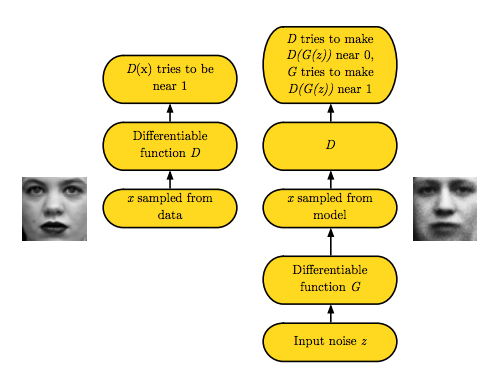

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 28
IMG_W = 28
IMG_C = 1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

# DCGAN


DCGAN 是 Deep Convolutional Generative Adversarial Networks 的縮寫。這是一篇在圖像任務上表現出色的論文，其架構提高了訓練穩定性和生成樣本的質量。在這個實驗室中，我們將修改 DCGAN 的程式碼，並演示在 MNIST 數據集上訓練 DCGAN 的過程。

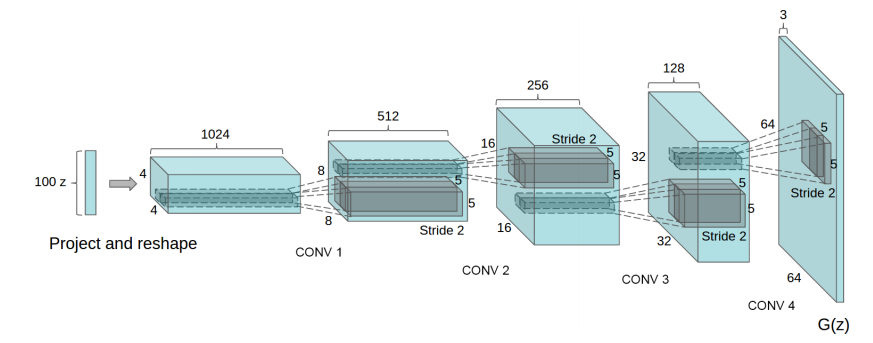


DCGAN中的一些建議（參考論文）：

- 將任何池化層替換為 strided convolutions （鑑別器）和 fractional-strided convolutions （生成器）。
    - 每個卷積層將特徵圖的解析度減半（非硬性要求）。
- 在生成器和鑑別器中都使用批次標準化。
    - 這裡的批次標準化是最簡單的，僅對特徵激活進行歸一化。
    - **不要在生成器的最後幾層使用批次標準化**，因為這可能使生成器難以適應真實數據的變化。例如，如果數據的平均值不為零，而我們在G的最後一層使用批次標準化和tanh，則它永遠不會與真實數據分佈匹配。
- 在生成器中，對所有層使用ReLU激活，除了輸出層，該層使用tanh或sigmoid。
    - 取決於真實數據的範圍。
- 在鑑別器中，對所有層使用LeakyReLU激活。
    - LeakyReLU由AllConvNet方法推薦，以實現更快的訓練。

- 在以下代碼中 :
    1. 我們按照DCGAN提出的建議設計模型架構
    2. 初始化DCGAN並在MNIST數據集上進行訓練。

In [ ]:
# Load images, discard labels
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [ ]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [ ]:
DC_G, DC_D = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(DC_LR)
optimizer_d = keras.optimizers.Adam(DC_LR)

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def DC_G_Loss(c0):
    """
    c0: logits of fake images
    """
    return cross_entropy(tf.ones_like(c0), c0)

def DC_D_Loss(c0, c1):
    """
    c0: logits of fake images
    c1: logits of real images
    """
    l1 = cross_entropy(tf.ones_like(c1), c1)
    l0 = cross_entropy(tf.zeros_like(c0), c0)
    return l1 + l0

@tf.function
def DC_D_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

        z0 = DC_D(c0, training = True)
        z1 = DC_D(c1, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_d = tp.gradient(ld, DC_D.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, DC_D.trainable_variables))
    
    return lg, ld

@tf.function
def DC_G_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

       
        z1 = DC_D(c1, training = True)
        z0 = DC_D(c0, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_g = tp.gradient(lg, DC_G.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, DC_G.trainable_variables))
    
    return lg, ld

In [ ]:
# ratio of training step D:G = 5:1
DCTrain = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

DCCritic = len(DCTrain)

讓我們在初始化之後繪製生成的圖像。檢查是否有任何意外的畫面異常。對於 DCGAN，如果我們使用完全卷積層，我們應該在生成的樣本中看到棋盤效應。正如這篇博客文章中所提到的，這會引入一些棋盤效應。如果訓練成功，那麼這種效應可以被大大減少。該博客文章使用上採樣來替換生成器中的步進反卷積。這可以取消掉棋盤效應，但結果會更模糊。

在下面的代碼中，我們還會繪製原始的 MNIST 數據集。

In [ ]:
print("Generator Initial Output :")
c0 = DC_G(tf.random.normal((1, Z_DIM)), training = False)
plt.imshow((c0[0, :, :, 0] * 255.0).numpy().astype(np.uint8), cmap = "gray")
plt.axis("off")
plt.show()
print("Discriminator Initial Output : %E" % DC_D(c0).numpy())

In [ ]:
dc_lg = [None] * DC_EPOCH #record loss of g for each epoch
dc_ld = [None] * DC_EPOCH #record loss of d for each epoch
dc_sp = [None] * DC_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in range(DC_EPOCH):
    loss_g_t = 0.0
    loss_d_t = 0.0
    for batch in dsTrain:
        loss_g, loss_d = DCTrain[ctr](batch)
        ctr += 1
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()
        if ctr == DCCritic : ctr = 0
    dc_lg[ep] = loss_g_t * rsTrain
    dc_ld[ep] = loss_d_t * rsTrain
    
    out = DC_G(s, training = False)
    out = np.repeat(out, 3, axis=-1)

    img = utPuzzle(
        (out * 255.0).astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/dc_%04d.png" % ep
    )
    dc_sp[ep] = img
    if (ep + 1) % 32 == 0:
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [ ]:
utMakeGif(np.array(dc_sp), "imgs/dcgan.gif", duration = 2)


我們繪製判別器和生成器的訓練損失。我們可以看到從訓練損失中無法判斷模型是否已經收斂。這兩條曲線在某個水平上波動，而這與生成的圖像的質量無關。因此，在實踐中，我們繪製生成的樣本以監控訓練過程。由於這種不便，一些在2017年提出的工作嘗試解決這個問題。

In [ ]:
plt.plot(range(DC_EPOCH), dc_ld, color = "blue", label = "Discriminator Loss")
plt.plot(range(DC_EPOCH), dc_lg, color = "red",  label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss")
plt.show()

# <center>Wasserstein GAN<center/>


傳統的生成對抗網絡（GAN）存在一些理論上的缺陷。為了解決這些問題，提出了 [Wasserstein GAN（WGAN）](https://arxiv.org/pdf/1701.07875.pdf)。除了原始論文外，這裡和[這裡](https://www.alexirpan.com/2017/02/22/wasserstein-gan.html)可能會幫助你理解WGAN的動機。在本教程中，我們將跳過理論部分，直接轉向實現。從工程的角度來看，以下是與原始GAN相比的修改。
- 不對評論者的最後一層應用sigmoid函數。
- 不對生成器損失和評論者損失應用對數函數。
- 每次生成器迭代都要訓練評論者多次。
- 使用RMSProp作為優化器，而不是像Adam這樣與動量相關的優化器。[這裡](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop)是梯度下降優化算法的一個 blog 概述。
- 在評論者網絡中應用權重修剪。

Details of the algorithm are shown below.

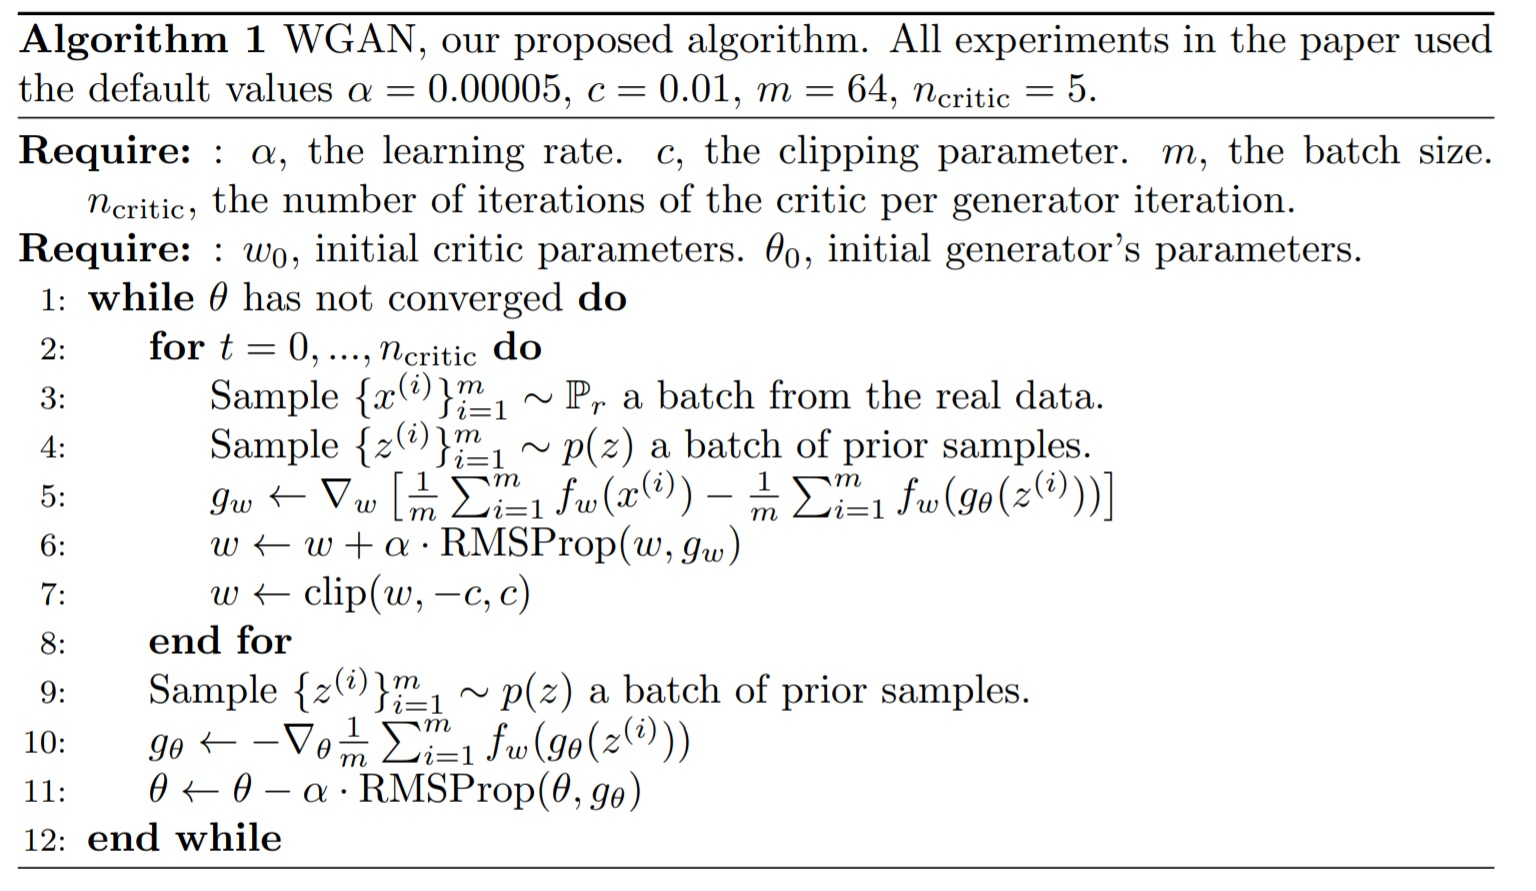

In [13]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.RMSprop(W_LR)
optimizer_d = keras.optimizers.RMSprop(W_LR)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    # clipping
    for v in WD.trainable_variables: 
        v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [14]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

Then we train the WGAN and visualize the training as before.

In [15]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    out = np.repeat(out, 3, axis=-1)
    img = utPuzzle(
        (out * 255.0).astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

ValueError: Can't write images with one color channel.

In [ ]:
utMakeGif(np.array(wsp), "imgs/wgan.gif", duration = 2)